In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pandas as pd
import pymysql as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
try:
    connection = pm.connect(host='localhost',
                             user='root',
                             password='Tashe@1129',
                           database='faostat')

    print("Connection successful to server MySQL")
    
except:
    print("Connection to database failed")

Connection successful to server MySQL


In [12]:
query = '''SELECT pi.Year_code,pi.Years,c.*,p.*,ca.Category,ca.Sub_category,pi.Information_code,pi.Information,(pi.Total_value*1000000) AS Total_value FROM category ca
            INNER JOIN product p USING (Category_code)
            INNER JOIN (SELECT product_information.*,years.Years,information.Information FROM information  
                        INNER JOIN product_information  USING (Information_code)
                        INNER JOIN years  USING (Year_code)) pi USING (Product_code)
            INNER JOIN country c USING (Area_code)'''
df_produits = pd.read_sql(query,connection)
df_produits

,Year_code,Years,Area_code,Area,Product_code,Product,Category_code,Category,Sub_category,Information_code,Information,Total_value
0,2018,2018,1,Armenia,2531,"""Potatoes and products""",1,Vegetal product,General,645,Food supply quantity (kg/capita/yr),3.419000e+07
1,2018,2018,1,Armenia,2531,"""Potatoes and products""",1,Vegetal product,General,664,Food supply (kcal/capita/day),6.400000e+07
2,2018,2018,1,Armenia,2531,"""Potatoes and products""",1,Vegetal product,General,674,Protein supply quantity (g/capita/day),1.500000e+06
3,2018,2018,1,Armenia,2531,"""Potatoes and products""",1,Vegetal product,General,684,Fat supply quantity (g/capita/day),9.000000e+04
4,2018,2018,1,Armenia,2531,"""Potatoes and products""",1,Vegetal product,General,5072,Stock Variation,-5.000000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
909980,2014,2014,5000,World,2516,"""Oats""",3,Vegetal Product,Cereal,5511,Production,2.282600e+10
909981,2014,2014,5000,World,2517,"""Millet and products""",3,Vegetal Product,Cereal,5511,Production,2.831600e+10
909982,2014,2014,5000,World,2518,"""Sorghum and products""",3,Vegetal Product,Cereal,5511,Production,6.698100e+10
909983,2014,2014,5000,World,2520,"""Cereals, Other""",3,Vegetal Product,Cereal,5511,Production,3.162800e+10


In [13]:
#Transform the per day details to per year (*365)
df_produits.Total_value = np.where(df_produits.Information.str.contains("kcal"),df_produits.Total_value*365,df_produits.Total_value)
df_produits.Total_value = np.where(df_produits.Information.str.contains("Fat"),df_produits.Total_value*365,df_produits.Total_value)
df_produits.Total_value = np.where(df_produits.Information.str.contains("Protein"),df_produits.Total_value*365,df_produits.Total_value)

In [14]:
#Transform g to kg (/1000)
df_produits.Total_value = np.where(df_produits.Information.str.contains("Fat"),df_produits.Total_value/1000,df_produits.Total_value)
df_produits.Total_value = np.where(df_produits.Information.str.contains("Protein"),df_produits.Total_value/1000,df_produits.Total_value)

In [15]:
#Change information
df_produits['Information'] = np.where(df_produits.Information.str.contains("kcal"),"Food supply (kcal/capita/yr)",df_produits.Information)
df_produits['Information'] = np.where(df_produits.Information.str.contains("Fat"),"Fat supply quantity (kg/capita/yr)",df_produits.Information)
df_produits['Information'] = np.where(df_produits.Information.str.contains("Protein"),"Protein supply quantity (kg/capita/yr)",df_produits.Information)

In [16]:
#Drop China states from population
df_produits.drop(df_produits[(df_produits['Area'].str.contains('china',case=False)) & (df_produits['Area']!='China')].index,inplace=True)

In [17]:
df_produits = df_produits.groupby(['Years','Area','Product','Information']).sum().reset_index()[['Years','Area','Product','Information','Total_value']]

In [18]:
# temp = df_produits[df_produits['Area'].str.contains("France") & df_produits['Area'].str.contains("France")]
# g = sns.FacetGrid(data = temp, col= 'Information', row = 'Product')
# g.map(sns.lineplot,'Years','Total_value')

In [19]:
query = '''SELECT y.*,c.*,u.Years_considered,u.Unit,u.Total_value FROM country c
                INNER JOIN undernourished u ON  c.Area_code=u.Area_code
                INNER JOIN years y ON u.Year_code=y.Year_code'''
df_undernourished = pd.read_sql(query,connection)
df_undernourished 

,Year_code,Years,Area_code,Area,Years_considered,Unit,Total_value
0,2014,2014,1,Armenia,"""2013,2014,2015""",millions,0.1
1,2014,2014,2,Afghanistan,"""2013,2014,2015""",millions,8.8
2,2014,2014,3,Albania,"""2013,2014,2015""",millions,0.1
3,2014,2014,4,Algeria,"""2013,2014,2015""",millions,1.3
4,2014,2014,7,Angola,"""2013,2014,2015""",millions,6.2
...,...,...,...,...,...,...,...
514,2018,2018,236,Venezuela (Bolivarian Republic of),"""2017,2018,2019""",millions,9.1
515,2018,2018,237,Viet Nam,"""2017,2018,2019""",millions,6.1
516,2018,2018,238,Ethiopia,"""2017,2018,2019""",millions,21.5
517,2018,2018,272,Serbia,"""2017,2018,2019""",millions,0.4


In [30]:
df_undernourished = df_undernourished.groupby(['Years','Area']).sum().reset_index()
df_undernourished.head()

,Years,Area,Year_code,Area_code,Total_value
0,2014,Afghanistan,2014,2,8.8
1,2014,Albania,2014,3,0.1
2,2014,Algeria,2014,4,1.3
3,2014,Angola,2014,7,6.2
4,2014,Armenia,2014,1,0.1


In [33]:
df_undernourished = df_undernourished.groupby('Area').mean().sort_values(by='Total_value',ascending=False).head(5).reset_index()
df_undernourished

,Area,Years,Year_code,Area_code,Total_value
0,India,2016.0,2016.0,100.0,192.32
1,Pakistan,2016.0,2016.0,165.0,25.88
2,Indonesia,2016.0,2016.0,101.0,23.86
3,Bangladesh,2016.0,2016.0,16.0,22.08
4,Ethiopia,2016.0,2016.0,238.0,21.98


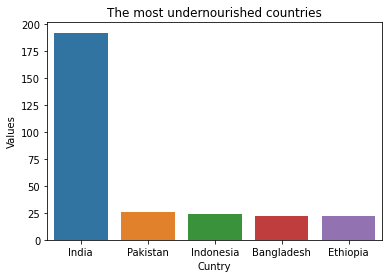

In [40]:
sns.barplot(data = df_undernourished , x = 'Area', y = 'Total_value')
plt.title('The most undernourished countries')
plt.xlabel("Cuntry")
plt.ylabel("Values")
plt.show()

In [44]:
countries_undernourished = list(df_undernourished['Area'])
countries_undernourished

['India', 'Pakistan', 'Indonesia', 'Bangladesh', 'Ethiopia']

In [46]:
df_produits = df_produits[df_produits['Area'].isin(countries_undernourished)]

In [49]:
df_produits.groupby(['Area','Product']).mean().reset_index()

,Area,Product,Years,Total_value
0,Bangladesh,"""Alcohol, Non-Food""",2015.935484,0.000000e+00
1,Bangladesh,"""Apples and products""",2016.000000,8.377414e+07
2,Bangladesh,"""Aquatic Animals, Others""",2016.000000,1.000000e+04
3,Bangladesh,"""Aquatic Plants""",2016.000000,2.340000e+04
4,Bangladesh,"""Bananas""",2016.000000,4.078432e+08
...,...,...,...,...
480,Pakistan,"""Tomatoes and products""",2016.000000,2.279097e+08
481,Pakistan,"""Vegetables, Other""",2016.044118,9.921989e+08
482,Pakistan,"""Wheat and products""",2016.000000,2.621394e+10
483,Pakistan,"""Wine""",2016.000000,0.000000e+00
